In [121]:
import os
# os.chdir(os.path.dirname(os.path.abspath(__file__)))
from glob import glob
import re, numpy as np

toplot = sorted(glob('./*averaged*.csv'))

toplot = {int(re.search(r'_(\d\d+)spl',x).group(1)):x for x in toplot}
print(toplot)

{1024: '.\\measures_1024spl_averaged.csv', 256: '.\\measures_256spl_averaged copy.csv', 64: '.\\measures_64spl_averaged.csv'}


In [122]:
import pandas as pd
# Load data
dataDict = {k:pd.read_csv(v) for k,v in toplot.items()}
# Convert to a single dataframe, where the key is checked against the 'spl' column of the item (pd dataframe)
for key,item in dataDict.items():
    for spl in item['spl']:
        # print(spl, key)
        assert spl == key, 'spl column does not match key ({} != {})'.format(spl, key)
# Now that we are sure, concat all the dataframes into a single one
data = pd.concat(dataDict.values())


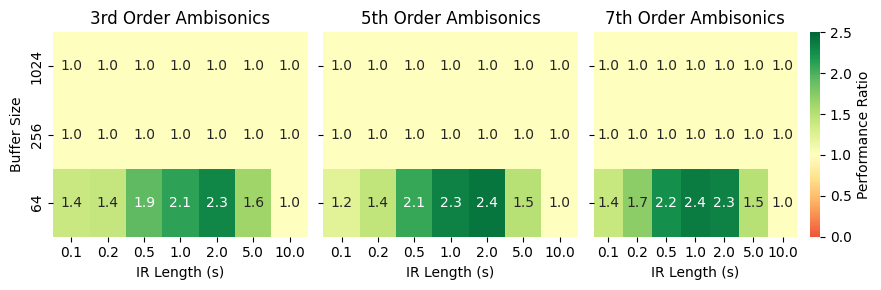

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

numeral_to_ordinal = lambda n: f'{n}{"tsnrhtdd"[((n//10%10!=1)*(n%10<4)*n%10)::4]}'

# Create performance ratio heatmap
def create_performance_heatmap(data, title=False):
    # newPlugin_data, oldPlugin_data, ambisonics_orders, buffer_sizes, ir_lengths, 
    channel_numbers = data['channels'].unique()
    ambisonics_orders = np.sqrt(channel_numbers)-1
    buffer_sizes = data['spl'].unique()
    ir_lengths = data['irlen_s'].unique()

    # print(channel_numbers, ambisonics_orders, buffer_sizes, ir_lengths)
    # oldPlugin_data should be in the shape of (channel_numbers, buffer_sizes, ir_lengths) and taken from data
    def get_plottable(data, plugin, channel_numbers, buffer_sizes, ir_lengths):
        plottable = np.zeros((len(channel_numbers), len(buffer_sizes), len(ir_lengths)))
        for idx, channels in enumerate(channel_numbers):
            for idx2, buffer_size in enumerate(buffer_sizes):
                for idx3, ir_length in enumerate(ir_lengths):
                    plottable[idx, idx2, idx3] = data[(data['channels'] == channels) & (data['spl'] == buffer_size) & (data['irlen_s'] == ir_length) & (data['plugin'] == plugin)]['X_mean'].values[0]
        return plottable
    
    oldPlugin_data = get_plottable(data, 'old', channel_numbers, buffer_sizes, ir_lengths)
    newPlugin_data = get_plottable(data, 'new', channel_numbers, buffer_sizes, ir_lengths)


    # Calculate performance ratio
    performance_ratio = newPlugin_data/oldPlugin_data
    
    # Create figure with subplots for different ambisonic orders
    fig, axes = plt.subplots(1, len(ambisonics_orders), figsize=(9, 3), sharey=True)
    if title:
        fig.suptitle('Speedup ratio of New MCFX-6DoFConv Plugin over SPARTA 6DoFConv', fontsize=16)
    
    # Plot heatmap for each ambisonics order
    for idx, order in enumerate(ambisonics_orders):
        # Extract data for specific ambisonics order
        data = performance_ratio[idx, :, :]
        
        round_to_next_half = lambda x: np.ceil(x*2)/2

        # # Create heatmap
        # sns.heatmap(data, 
        #             ax=axes[idx], 
        #             cmap='RdYlGn',  # Red-Yellow-Green reversed (red = worse, green = better)
        #             cbar=idx == len(ambisonics_orders)-1,  # Only add colorbar to last subplot
        #             annot=True, 
        #             fmt='.1f',
        #             vmin=0, 
        #             vmax=round_to_next_half(max(performance_ratio.max(), 1.5)),
        #             center=1,
        #             cbar_kws={'label': 'Performance Ratio'} if idx == len(ambisonics_orders)-1 else {})
        
        # Create a mask for bold borders
        # mask = np.logical_not(newPlugin_data[idx, :, :] > 1)
        # mask = np.logical_not(oldPlugin_data[idx, :, :] > 1)

        # Create heatmap
        sns.heatmap(data, 
                    ax=axes[idx], 
                    cmap='RdYlGn',  # Red-Yellow-Green reversed (red = worse, green = better)
                    cbar=idx == len(ambisonics_orders)-1,  # Only add colorbar to last subplot
                    annot=True, 
                    fmt='.1f',
                    vmin=0, 
                    vmax=round_to_next_half(max(performance_ratio.max(), 1.5)),
                    center=1,
                    cbar_kws={'label': 'Performance Ratio'} if idx == len(ambisonics_orders)-1 else {})
        
        # Set labels
        axes[idx].set_xlabel('IR Length (s)')
        axes[idx].set_xticklabels(ir_lengths, rotation=0)

        
        if idx == 0:
            axes[idx].set_ylabel('Buffer Size')
        
        axes[idx].set_yticklabels(buffer_sizes)


        axes[idx].set_title(f'{numeral_to_ordinal(int(order))} Order Ambisonics')
    
    plt.tight_layout()


# Main execution
create_performance_heatmap(data)

outfile = os.path.join('outplots','speedup_heatmap')
plt.savefig(outfile+'.png', bbox_inches='tight')
plt.savefig(outfile+'.pdf', bbox_inches='tight')
plt.savefig(outfile+'.svg', bbox_inches='tight')
plt.show()

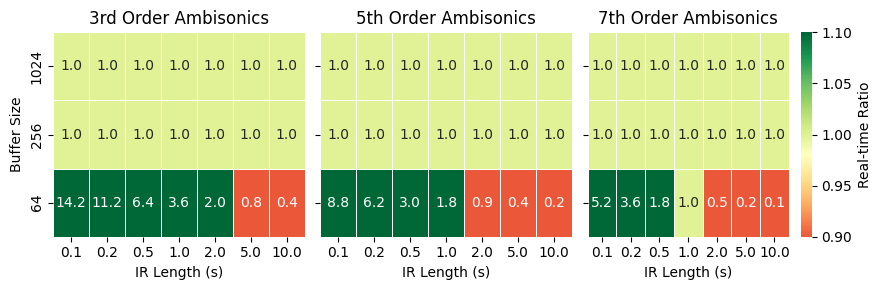

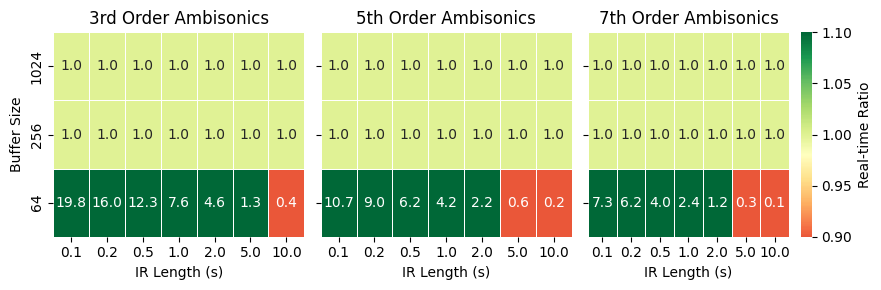

In [134]:
def create_rtratio_minimal_heatmap(data, plugin, title=False):
    channel_numbers = data['channels'].unique()
    buffer_sizes = data['spl'].unique()
    ir_lengths = data['irlen_s'].unique()
    ambisonics_orders = np.sqrt(channel_numbers)-1

    def get_plottable(data, plugin, channel_numbers, buffer_sizes, ir_lengths):
        plottable = np.zeros((len(channel_numbers), len(buffer_sizes), len(ir_lengths)))
        for idx, channels in enumerate(channel_numbers):
            for idx2, buffer_size in enumerate(buffer_sizes):
                for idx3, ir_length in enumerate(ir_lengths):
                    plottable[idx, idx2, idx3] = data[(data['channels'] == channels) & (data['spl'] == buffer_size) & (data['irlen_s'] == ir_length) & (data['plugin'] == plugin)]['X_mean'].values[0]
        return plottable

    # Now, instead of computing the ratio, we plot a headmap for each of the plugins, and plot directly the values
    assert plugin in ['old','new'], 'plugin must be either "old" or "new"'
    plugindata = get_plottable(data, plugin, channel_numbers, buffer_sizes, ir_lengths)
    

    fig, axes = plt.subplots(1, len(ambisonics_orders), figsize=(9, 3), sharey=True)
    if title:
        fig.suptitle('Real-time ratio for'+('SPARTA 6DoFConv' if plugin=='old' else 'MCFX-6DoFConv Plugin'), fontsize=16)
    for idx, order in enumerate(ambisonics_orders):
        # Extract data for specific ambisonics order
        data = plugindata[idx, :, :]
        
        round_to_next_half = lambda x: np.ceil(x*2)/2

        # # Create heatmap
        # sns.heatmap(data, 
        #             ax=axes[idx], 
        #             cmap='RdYlGn',  # Red-Yellow-Green reversed (red = worse, green = better)
        #             cbar=idx == len(ambisonics_orders)-1,  # Only add colorbar to last subplot
        #             annot=True, 
        #             fmt='.1f',
        #             vmin=0, 
        #             vmax=round_to_next_half(max(performance_ratio.max(), 1.5)),
        #             center=1,
        #             cbar_kws={'label': 'Performance Ratio'} if idx == len(ambisonics_orders)-1 else {})
        
        # Create a mask for bold borders
        # mask = np.logical_not(newPlugin_data[idx, :, :] > 1)
        # mask = np.logical_not(oldPlugin_data[idx, :, :] > 1)

        # Create heatmap
        sns.heatmap(data, 
                    ax=axes[idx], 
                    cmap='RdYlGn',  # Red-Yellow-Green reversed (red = worse, green = better)
                    cbar=idx == len(ambisonics_orders)-1,  # Only add colorbar to last subplot
                    annot=True, 
                    fmt='.1f',
                    # vmin=0.9, 
                    # vmax=round_to_next_half(max(oldPlugin_data.max(), oldPlugin_data.max())),
                    # center=5,
                    vmin=0.9, 
                    vmax=1.1,
                    center=0.98,
                    cbar_kws={'label': 'Real-time Ratio'} if idx == len(ambisonics_orders)-1 else {},
                    annot_kws={'size': 10, 'rotation': 0},
                    linewidths=.5,  # Make the gridlines thicker
                    linecolor='white',  # Color of the gridlines
                    )
        
        # Set labels
        axes[idx].set_xlabel('IR Length (s)')
        axes[idx].set_xticklabels(ir_lengths, rotation=0)

        
        if idx == 0:
            axes[idx].set_ylabel('Buffer Size')
        
        axes[idx].set_yticklabels(buffer_sizes)


        axes[idx].set_title(f'{numeral_to_ordinal(int(order))} Order Ambisonics')
    plt.tight_layout()


for plugin in ['old','new']:
    create_rtratio_minimal_heatmap(data,plugin)
    outfile = os.path.join('outplots','rtratio_heatmap_%s'%(plugin))
    plt.savefig(outfile+'.png', bbox_inches='tight')
    plt.savefig(outfile+'.svg', bbox_inches='tight')
    plt.savefig(outfile+'.pdf', bbox_inches='tight')
    plt.show()